## VAE and InfoVAE on a bimodal gaussian distribution
A closer look at real-world data from eruptions at the Old Faithful in Yellowstone.

Eruption durations and wait time between eruptions at the Old Faithful approximately follow a bimodal gaussian distribution.

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import torch
import torch.nn as nn
import torch.utils.data as tdata
from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

import vaes_ptorch.args as args
import vaes_ptorch.models as models
import vaes_ptorch.train_vae as train_vae
import vaes_ptorch.vae as vae_nn

In [4]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

/Users/arnaudautef/miniconda3/envs/vaes/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.stat.cmu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


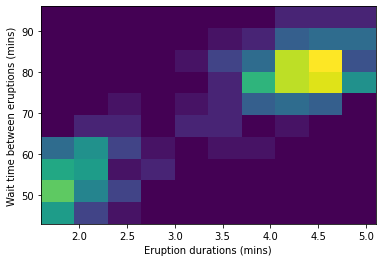

In [5]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

(272, 2)

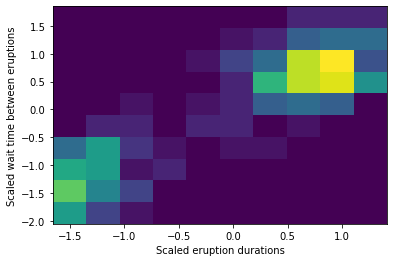

In [6]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
data, _ = scale_data(data)
plt.hist2d(data[:, 0], data[:, 1], alpha=1.0)
plt.xlabel("Scaled eruption durations")
plt.ylabel("Scaled wait time between eruptions")
data.shape

In [7]:
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([-1.27396762, -1.20991826]), array([0.7038525 , 0.66846596])], sigma=[array([[0.05329039, 0.02814822],
       [0.02814822, 0.18299437]]), array([[0.13095257, 0.06084201],
       [0.06084201, 0.19575032]])], gamma=array([0.35587286, 0.64412714]))

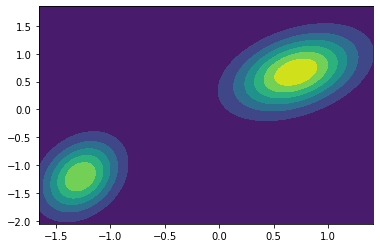

In [8]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), num=100)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), num=100)
X, Y = np.meshgrid(x, y)

XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)

pdfs = (
    sts.multivariate_normal.pdf(XY, theta.mu[0], theta.sigma[0])
    * theta.gamma[0]
    + sts.multivariate_normal.pdf(XY, theta.mu[1], theta.sigma[1])
    * theta.gamma[1]
)

plt.contourf(X, Y, pdfs)

In [44]:
data_dim = 2
latent_dim = 1

h_size = 128
h_layers = 3

lr = 1e-3
batch_size = 64
num_epochs = 500

print_every = 100

info_vae = True
end_scale = 1.0

# info_vae = False
# end_scale = 0.005

In [45]:
dataset = tdata.TensorDataset(torch.from_numpy(data).float())

In [46]:
def simple_collate(data):
    return torch.cat([x[0].unsqueeze(0) for x in data])

In [48]:
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=simple_collate
)

In [49]:
encoder = models.get_mlp(
        in_dim=data_dim,
        out_dim=2 * latent_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    )
decoder = models.get_mlp(
        in_dim=latent_dim,
        out_dim=2 * data_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    )
vae = vae_nn.GaussianVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    obs_model=vae_nn.ObsModel.Gaussian,
    device="cpu",
)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = args.TrainArgs(
    num_epochs=num_epochs,
    info_vae=info_vae,
    print_every=print_every,
    target_div_scale=end_scale,
)

In [50]:
train_vae.train(
    train_data=dataloader, vae=vae, optimizer=optimizer, train_args=train_args
)

Training logs for step: 100, epoch: 20
loss: 0.71800 | nll: 0.63510 | div: 0.08290
Training logs for step: 200, epoch: 40
loss: -0.70948 | nll: -0.80878 | div: 0.09931
Training logs for step: 300, epoch: 60
loss: 2.35117 | nll: 2.26411 | div: 0.08705
Training logs for step: 400, epoch: 80
loss: -0.78841 | nll: -0.92479 | div: 0.13638
Training logs for step: 500, epoch: 100
loss: 0.49514 | nll: 0.43815 | div: 0.05700
Training logs for step: 600, epoch: 120
loss: -1.32190 | nll: -1.35921 | div: 0.03730
Training logs for step: 700, epoch: 140
loss: -0.36353 | nll: -0.44783 | div: 0.08430
Training logs for step: 800, epoch: 160
loss: -1.19744 | nll: -1.23789 | div: 0.04044
Training logs for step: 900, epoch: 180
loss: -1.47146 | nll: -1.51491 | div: 0.04345
Training logs for step: 1000, epoch: 200
loss: -1.75463 | nll: -1.80985 | div: 0.05523
Training logs for step: 1100, epoch: 220
loss: -0.25804 | nll: -0.38685 | div: 0.12880
Training logs for step: 1200, epoch: 240
loss: -1.33229 | nll:

({'loss': -1.784354814580617,
  'nll': -1.857621479065063,
  'div': 0.07326666128185588},
 {})

In [91]:
def plot_pdf_2d(xs, ys, zs, to_dist):
    p_x_given_z = to_dist(zs)
    X, Y = np.meshgrid(xs, ys)
    XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)
    pdf = torch.exp(p_x_given_z.log_prob(torch.from_numpy(XY)).sum(-1)).mean(0).detach().numpy()
    plt.contourf(X, Y, pdf)


n_monte_carlo_samples = 500

### Inference

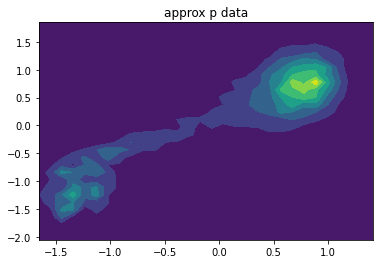

In [92]:
n = 30
x_grid = np.linspace(data[:, 0].min(), data[:, 0].max(), num=n)
y_grid = np.linspace(data[:, 1].min(), data[:, 1].max(), num=n)
z_samples = torch.randn((n_monte_carlo_samples, n, n, latent_dim))

vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf_2d(x_grid, y_grid, z_samples, vae.decode)
    plt.title("approx p data")
    plt.show()
    plt.close()

### Generation

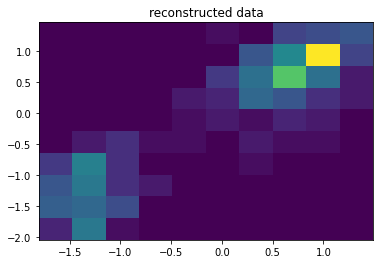

In [93]:
vae.eval()
with torch.no_grad():
    plt.figure()
    _, p_x_given_z = vae(torch.from_numpy(data).float())
    reconstructed = p_x_given_z.sample().detach().numpy()
    plt.hist2d(reconstructed[:, 0], reconstructed[:, 1], alpha=1.0)
    plt.title("reconstructed data")
    plt.show()
    plt.close()